In [56]:
import numpy as np
from scipy.interpolate import interp1d 
import seaborn as sns
import time
import pandas as pd
import pickle

# load data calcualted from the previous part
wa = np.loadtxt('w_a.csv', delimiter=',')
wb = np.loadtxt('w_b.csv', delimiter=',')

# set up a seed to repeat experiments
np.random.RandomState(seed=111)

# ----------------------
# Global Constants------
# ----------------------
Re = 1.0
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# polymer contour
S = np.linspace(0,1,N)
# cutting point of the polymer diving A and B
F = 1/2
L = 2*Re
X = np.linspace(0,Nx, Nx)
X = X*L/Nx

# ---------------------------------------
# DEFINITION OF FUNCTIONS
# ----------------------------------------

# choose and move one bead of the chain
def move_bead(current_chain,d_interval):
    # selects a bead at random and moves it
    # args-> current_chain: array, contains the positions of the current chain
    #        d_interval: displacement interval
    # returns-> proposed_move: array, chain with one displaced bead
    #           bead_index: index indicating which bead was moved
    Delta = np.random.uniform(low=-d_interval,high=d_interval)

    # chose the bead
    proposed_move = current_chain.copy()
    bead_index = np.random.randint(0,N)
    proposed_move[bead_index,:] = proposed_move[bead_index,:] + Delta
    
    return proposed_move, bead_index


def metropolis_step(d_u, prev_chain, proposed_chain):
    # decides whether to accept the newt move or not
    # args --> d_u: scalar, change in energy between prev_chain and proposed_chain
    #          prev_chain: proposed_chain: arrays. Previous and proposed chain respecively
    # returns: next_chain: the chain for the next step, it can be prev_chain (if rejected) or proposed_chain (if accepted)
    #          accepted: integer. Indicates if the move was accepted (=1) or rejected (=0)
    next_chain = prev_chain.copy()
    accepted = 0
    
    # if negative change we accept    
    if(d_u <= 0):
        next_chain = proposed_chain.copy()
        accepted = 1

    else:
        # draw a random number
        coin_toss = np.random.uniform(0,1)
        dist_delta = np.exp(-d_u)

        if(coin_toss<dist_delta):
            next_chain = proposed_chain.copy()
            accepted = 1
            
    return next_chain, accepted


In [59]:
def calculate_energy_faster(bead_chain, no_fields=False):
    # calculates the energy for a given chain
    # args -> bead_chain: array, represents the chain to calculate the energy, includes position for each bead
    #        no_fields: boolean, indicates whether we set the fields to zero or not
    # returns- > U: scalar, the enery of bead_chain
    
    s1_mag = bead_chain[1:] - bead_chain[:-1]    
    s1 =np.sum(s1_mag*s1_mag, axis=1)
    
     # term dependent on wa remember only the x value is important
    swa = wa_int(bead_chain[:,0])
    # term dependent on wb
    swb = wb_int(bead_chain[:,0])
        
    mask_wa = np.zeros(len(swa))
    mask_wb = np.zeros(len(swb))
    
    if no_fields == False:
        # mask wa and wb such that they  act only on their respective sectors of the chain
        mask_wa[:int(F*N)] = 1
        mask_wb[int(F*N):] = 1
        
    # evaluate the sums as dot products
    U = 3*(N-1)/(2*Re**2) * np.sum(s1) + (1/N)*np.dot(mask_wa,swa) + (1/N)*np.dot(mask_wb,swb)
    
    return U, swa, swb, s1

def create_initial_chain():
    dims = 3
    step_n = N
    delta_x = (X[1]-X[0])*2
    step_set = [-delta_x, 0, delta_x]
    origin = np.zeros((1,dims))
    # Simulate steps in 3D
    step_shape = (step_n,dims)
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)

    path[path<0]=0 + np.random.rand()*delta_x
    path[path>L]=L - np.random.rand()*delta_x
    
    return path



In [68]:
# -----------------------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------------------

d = (X[1]-X[0])*10

# interpolation of the fields
wa_int = interp1d(X,wa, kind='linear')
wb_int = interp1d(X,wb, kind='linear')

# number of polymers 
N_polymers = 1
# number of montecalo steps
N_montecarlo = 2000
turn_of_fields = True

u_list = []
# positions
montecarlo_chains = []
# center of mass data
cm_list = []
# junction points
jp_list = []

for k in range(0, N_polymers):

    #initial_chain = np.random.rand(N,3) * L
    initial_chain = create_initial_chain()
    current_chain = initial_chain.copy()

    # meassure time taken
    start = time.time()
    print("Starting")

    for j in range(N_montecarlo):
        acceptance_list = np.zeros(Nx)
        current_u = 0
        # one montecarlo step
        for i in range(0,Nx):
            next_chain, bead_i = move_bead(current_chain,d)
            # if the displacement takes the bead out of the box then we reject the move immediately
            if all((y <= L) and (y>=0) for y in next_chain[bead_i]):
                # calculate initial and final energies
                u0,sumwa0, sumwb0, sum0 = calculate_energy_faster(current_chain,no_fields=turn_of_fields)
                uf,sumwaf, sumwbf, sumf = calculate_energy_faster(next_chain,no_fields=turn_of_fields)

                delta_u = uf-u0

                # metropolis step 
                current_chain, acceptance_list[i] = metropolis_step(delta_u, current_chain, next_chain)
                
                if acceptance_list[i] == 0:
                    delta_u = 0
                    current_u = u0
                    
                else:
                    current_u = uf
                    
            # reject the move if the bead goes out of the box
            else:
                delta_u = 0
                current_u = u0
                
        u_list.append(current_u)

        # calculate the center of mass data for each monte carlo step
        current_cm = (1/N)*np.sum(current_chain,axis=0)
        cm_list.append(current_cm)

        current_jp = (1/2)*( current_chain[int(N*F-1),:] + current_chain[int(N*F),:] )
        jp_list.append(current_jp)

        # print the time to look at something while it iterates
        if(j%100==0):
            now = time.time()
            print("{0} seconds since the loop started".format(now - start), " and ", j+1, "iterations")
                
    # save current chain positions
    montecarlo_chains.append(current_chain)

    print('-------------------------------------------')
    print('next polymer')
    print('-------------------------------------------')
                

end = time.time()
print(end - start)



Starting
0.10445690155029297 seconds since the loop started  and  1 iterations
5.1253650188446045 seconds since the loop started  and  101 iterations
10.764855146408081 seconds since the loop started  and  201 iterations
16.205147981643677 seconds since the loop started  and  301 iterations
21.2725830078125 seconds since the loop started  and  401 iterations
26.58873701095581 seconds since the loop started  and  501 iterations
32.19449496269226 seconds since the loop started  and  601 iterations
37.64924192428589 seconds since the loop started  and  701 iterations
42.965659856796265 seconds since the loop started  and  801 iterations
47.74017000198364 seconds since the loop started  and  901 iterations
52.9950909614563 seconds since the loop started  and  1001 iterations
58.644712924957275 seconds since the loop started  and  1101 iterations
64.15284609794617 seconds since the loop started  and  1201 iterations
70.77905678749084 seconds since the loop started  and  1301 iterations
75.8

In [69]:
import matplotlib.pyplot as plt

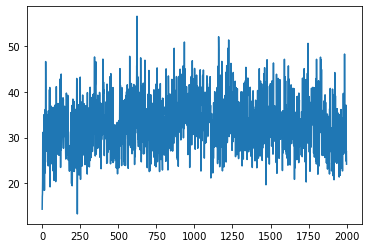

In [70]:
plt.plot(u_list)

(9000.0, 9100.0)

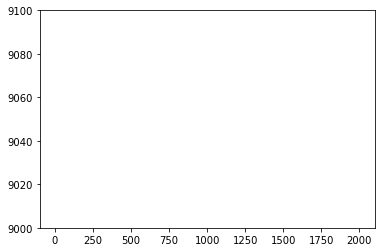

In [71]:
plt.plot(u_list)
plt.ylim(9000,9100)